# License Plate Recognition

In [51]:
import os

import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [38]:
# torch.manual_seed(0)
# random.seed(0)
# np.random.seed(0)

## Data preprocessing:

Load dataset:

In [2]:
# !unzip /content/drive/MyDrive/OCR/CCPD2019-dl1.zip

In [3]:
img_dir = "/content/CCPD2019-dl1"

In [62]:
class LicencePlateDataset(Dataset):
  def __init__(self, path, img_size=(128, 32), train=True, transform=None):
    super().__init__()
    self.img_dir = os.path.join(path, "train" if train else "test")
    self.images = [os.path.join(self.img_dir, img_filename) for img_filename in os.listdir(self.img_dir)]
    self.labels = [img_filename.split("-")[-1][:-4] for img_filename in self.images]
    self.img_size = img_size # (width, height)
    self.transform = transform
  
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img = cv2.imread(self.images[idx])
    # print("Original Dimension: ", img.shape)
    img = cv2.resize(img, self.img_size)
    # print("Resized Dimension: ", img.shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # print("GrayScaled Dimension: ", img.shape)
    if self.transform:
      img = self.transform(img)
    # img = img / 255.0
    # print(img.min(), img.max())
    label = self.labels[idx]
    return img, label

Create train and test datasets:

In [63]:
train_dataset = LicencePlateDataset(path=img_dir, train=True, transform=transforms.ToTensor())
test_dataset = LicencePlateDataset(path=img_dir, train=False, transform=transforms.ToTensor())

print(f"Number of images in train set: {len(train_dataset)}")
print(f"Number of images in test set: {len(test_dataset)}")

Number of images in train set: 199980
Number of images in test set: 9999


Let's have a look to 5 random images from train dataset:

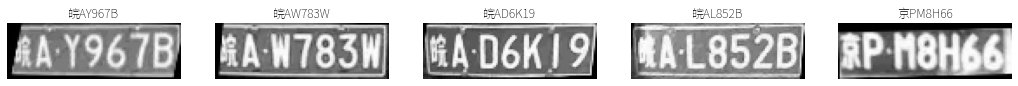

In [64]:
# the following code applies Chinese font to matplotlib
def change_matplotlib_font(font_download_url):
    FONT_PATH = "chinese_font"
    
    font_download_cmd = f"wget {font_download_url} -O {FONT_PATH}.zip"
    unzip_cmd = f"unzip -o {FONT_PATH}.zip -d {FONT_PATH}"
    os.system(font_download_cmd)
    os.system(unzip_cmd)
    
    font_files = fm.findSystemFonts(fontpaths=FONT_PATH)
    for font_file in font_files:
        fm.fontManager.addfont(font_file)

    font_name = fm.FontProperties(fname=font_files[0]).get_name()
    matplotlib.rc("font", family=font_name)

font_download_url = "https://fonts.google.com/download?family=Noto%20Sans%20SC"
change_matplotlib_font(font_download_url)

ids = np.random.randint(low=0, high=len(train_dataset), size=5)
plt.figure(figsize=(18, 6))
for i in range(5):
  plt.subplot(1, 5, i+1)
  # print(train_dataset[ids[i]][0].size())
  plt.imshow(train_dataset[ids[i]][0].squeeze(), cmap="gray")
  plt.title(train_dataset[ids[i]][1])
  plt.axis("off")

Create DataLoaders:

In [65]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model architecture (CRNN)

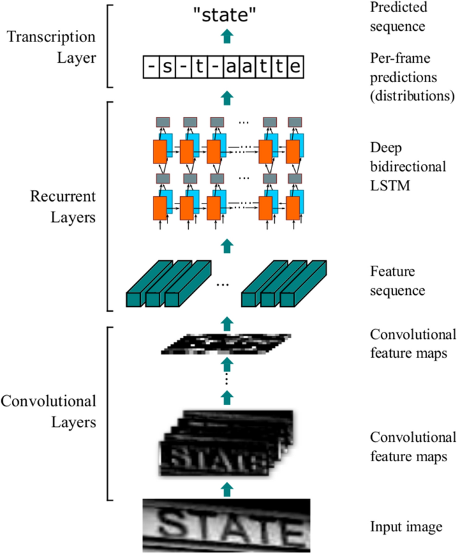  
Refer to https://arxiv.org/pdf/1507.05717.pdf for more details.

In [66]:
class CRNN(nn.Module):
  def conv_layer(self, in_channels, out_channels, kernel_size, padding, batch_norm=False):
    layers = [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding)]
    if batch_norm:
      layers.append(nn.BatchNorm2d(num_features=out_channels))
    layers.append(nn.ReLU())
    return nn.Sequential(*layers)
  
  def  __init__(self):
    super().__init__()

    self.conv0 = self.conv_layer(in_channels=1, out_channels=64, kernel_size=3, padding=1) # 1x32x128 -> 64x32x128
    self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2) # 64x32x128 -> 64x16x64
    self.conv1 = self.conv_layer(in_channels=64, out_channels=128, kernel_size=3, padding=1) # 64x16x64 -> 128x16x64
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128x16x64 -> 128x8x32
    self.conv2 = self.conv_layer(in_channels=128, out_channels=256, kernel_size=3, padding=1) # 128x8x32 -> 256x8x32
    self.conv3 = self.conv_layer(in_channels=256, out_channels=256, kernel_size=3, padding=1) # 256x8x32 -> 256x8x32
    self.pool2 = nn.MaxPool2d(kernel_size=(1,2), stride=2) # 256x8x32 -> 256x4x16
    self.conv4 = self.conv_layer(in_channels=256, out_channels=512, kernel_size=3, padding=1, batch_norm=True) # 256x4x16 -> 512x4x16
    self.conv5 = self.conv_layer(in_channels=512, out_channels=512, kernel_size=3, padding=1, batch_norm=True) # 512x4x16 -> 512x4x16
    self.pool3 = nn.MaxPool2d(kernel_size=(1,2), stride=2) # 512x4x16 -> 512x2x8
    self.conv6 = self.conv_layer(in_channels=512, out_channels=512, kernel_size=2, padding=0, batch_norm=True) # 512x2x8 -> 512x1x7
    # self.cnn = nn.Sequential(*self.layers)

  def forward(self, input):
    # CNN layers
    l0 = self.conv0(input)
    l1 = self.conv1(self.pool0(l0))
    l2 = self.conv2(self.pool1(l1))
    l3 = self.conv3(l2)
    l4 = self.conv4(self.pool2(l3))
    l5 = self.conv5(l4)
    l6 = self.conv6(self.pool3(l5))

    return l6

In [70]:
from torchsummary import summary

model = CRNN()
summary(model, (1,32,128), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [64, 64, 32, 128]             640
              ReLU-2          [64, 64, 32, 128]               0
         MaxPool2d-3           [64, 64, 16, 64]               0
            Conv2d-4          [64, 128, 16, 64]          73,856
              ReLU-5          [64, 128, 16, 64]               0
         MaxPool2d-6           [64, 128, 8, 32]               0
            Conv2d-7           [64, 256, 8, 32]         295,168
              ReLU-8           [64, 256, 8, 32]               0
            Conv2d-9           [64, 256, 8, 32]         590,080
             ReLU-10           [64, 256, 8, 32]               0
        MaxPool2d-11           [64, 256, 4, 16]               0
           Conv2d-12           [64, 512, 4, 16]       1,180,160
      BatchNorm2d-13           [64, 512, 4, 16]           1,024
             ReLU-14           [64, 512